In [1]:
#@markdown ### **Installing pip packages**
#@markdown - Diffusion Model: [PyTorch](https://pytorch.org) & [HuggingFace diffusers](https://huggingface.co/docs/diffusers/index)
#@markdown - Dataset Loading: [Zarr](https://zarr.readthedocs.io/en/stable/) & numcodecs
#@markdown - Push-T Env: gym, pygame, pymunk & shapely
!python --version
# !pip3 install torch==1.13.1 torchvision==0.14.1 diffusers==0.18.2 \
# scikit-image==0.19.3 scikit-video==1.1.11 zarr==2.12.0 numcodecs==0.10.2 \
# pygame==2.1.2 pymunk==6.2.1 gym==0.26.2 shapely==1.8.4 \
# &> /dev/null # mute output

Python 3.9.18


In [2]:
#@markdown ### **Imports**
# diffusion policy import
from typing import Tuple, Sequence, Dict, Union, Optional
import numpy as np
import math
import torch
import torch.nn as nn
import collections
import zarr
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from diffusers.training_utils import EMAModel
from diffusers.optimization import get_scheduler
from tqdm.auto import tqdm

# env import
import gym
from gym import spaces
import pygame
import pymunk
import pymunk.pygame_util
from pymunk.space_debug_draw_options import SpaceDebugColor
from pymunk.vec2d import Vec2d
import shapely.geometry as sg
import cv2
import skimage.transform as st
from skvideo.io import vwrite
from IPython.display import Video
import gdown
import os

/home/schen964/anaconda3/envs/robodiff/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


pygame 2.1.2 (SDL 2.0.16, Python 3.9.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [3]:
from diffusion_policy.env.block_pushing.block_pushing import BlockPush, BlockPushNormalized
from diffusion_policy.env.block_pushing.block_pushing_discontinuous import BlockPushDiscontinuous
from diffusion_policy.env.block_pushing.block_pushing_multimodal import BlockPushMultimodal
#@markdown ### **Env Demo**
#@markdown Standard Gym Env (0.21.0 API)

# 0. create env object
# env = PushTEnv()
# env = BlockPush()
# env = BlockPushNormalized()
# env = BlockPushDiscontinuous()
env = BlockPushMultimodal()

# 1. seed env for initial state.
# Seed 0-200 are used for the demonstration dataset.
env.seed(1000)

# 2. must reset before use
# obs, DEFAULT_IGNORE_PATTERNS = env.reset()
obs = env.reset()

# 3. 2D positional action space [0,512]
action = env.action_space.sample()

# 4. Standard gym step method
# obs, reward, terminated, truncated, info = env.step(action)
obs, reward, terminated, info = env.step(action)

# prints and explains each dimension of the observation and action vectors
with np.printoptions(precision=4, suppress=True, threshold=5):
    # print("Obs: ", repr(obs))
    # print("Obs:        [agent_x,  agent_y,  block_x,  block_y,    block_angle]")
    print('Obs:')
    for k,v in obs.items():
        print(f"\t{k}: {v}")
    print("Action: ", repr(action))
    # print("Action:   [target_agent_x, target_agent_y]")

argv[0]=
Obs:
	block_translation: (0.4307170873805668, -0.3154972989451979)
	block_orientation: [1.1064]
	block2_translation: (0.3139157624496881, -0.08439863792609263)
	block2_orientation: [1.1014]
	effector_translation: [ 0.3865 -0.3437]
	effector_target_translation: [ 0.3948 -0.3387]
	target_translation: [0.2774 0.2024]
	target_orientation: [3.1367]
	target2_translation: [0.5232 0.1961]
	target2_orientation: [0.0148]
Action:  array([0.0948, 0.0613], dtype=float32)


/home/schen964/anaconda3/envs/robodiff/lib/python3.9/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [4]:
#@markdown ### **Dataset Demo**
from diffusion_policy.dataset.blockpush_lowdim_dataset import BlockPushLowdimDataset

# download demonstration data from Google Drive
# dataset_path = "pusht_cchi_v7_replay.zarr.zip"
# dataset_path = "data/training/block_pushing/cutomized_push_b1_t1.zarr"
dataset_path = "data/training/block_pushing/combined_push_b1t1_b1t2.zarr"
# if not os.path.isfile(dataset_path):
    # id = "1KY1InLurpMvJDRb14L9NlXT_fEsCvVUq&confirm=t"
    # gdown.download(id=id, output=dataset_path, quiet=False)

# parameters
pred_horizon = 16
obs_horizon = 2
action_horizon = 8
#|o|o|                             observations: 2
#| |a|a|a|a|a|a|a|a|               actions executed: 8
#|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p|p| actions predicted: 16

# create dataset from file
# dataset = PushTStateDataset(
    # dataset_path=dataset_path,
    # pred_horizon=pred_horizon,
    # obs_horizon=obs_horizon,
    # action_horizon=action_horizon
# )
dataset = BlockPushLowdimDataset(
    zarr_path=dataset_path,
    horizon=pred_horizon,
    pad_before=obs_horizon-1,
    pad_after=action_horizon-1
)
# save training data statistics (min, max) for each dim
# stats = dataset.stats

# create dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=256,
    num_workers=1,
    shuffle=True,
    # accelerate cpu-gpu transfer
    pin_memory=True,
    # don't kill worker process afte each epoch
    persistent_workers=True
)

# visualize data in batch
batch = next(iter(dataloader))
print("batch['obs'].shape:", batch['obs'].shape)
print("batch['action'].shape", batch['action'].shape)

batch['obs'].shape: torch.Size([256, 16, 16])
batch['action'].shape torch.Size([256, 16, 2])


In [5]:
import zarr
zarr_ds = zarr.open('data/training/block_pushing/combined_push_b1t1_b1t2.zarr', 'r')

# Navigate to the 'data' group
data_group = zarr_ds['data']

# Check if the 'data' group is a group
if isinstance(data_group, zarr.Group):
    print("The 'data' group is a group. Listing arrays in the group:")
    total_size = 0
    for array_name, array in data_group.items():
        print(f"Array name: {array_name}")
        print(f"  Shape: {array.shape}")
        print(f"  Chunks: {array.chunks}")
        print(f"  Dtype: {array.dtype}")
        total_size += array.nbytes
    print(f"Total size of the 'data' group: {total_size} bytes")
else:
    print("The 'data' group is a single array.")
    print(f"Dataset shape: {data_group.shape}")
    print(f"Dataset chunks: {data_group.chunks}")
    print(f"Dataset dtype: {data_group.dtype}")
    print(f"Dataset size: {data_group.nbytes} bytes")

# Determine the number of demonstrations
if 'obs' in data_group and 'action' in data_group:
    obs_array = data_group['obs']
    action_array = data_group['action']
    num_demos = obs_array.shape[0]
    print(f"Number of demonstrations: {num_demos}")
else:
    print("The 'data' group does not contain 'obs' and 'action' arrays.")

The 'data' group is a group. Listing arrays in the group:
Array name: action
  Shape: (70200, 2)
  Chunks: (70200, 2)
  Dtype: float32
Array name: obs
  Shape: (70200, 16)
  Chunks: (31250, 16)
  Dtype: float32
Total size of the 'data' group: 5054400 bytes
Number of demonstrations: 70200


In [22]:
import zarr
import numpy as np

# Paths to the Zarr datasets
dataset_path_abs = 'data/training/block_pushing/multimodal_push_seed_abs.zarr'
dataset_path_rel = 'data/training/block_pushing/multimodal_push_seed.zarr'

# Open the Zarr datasets
zarr_ds_abs = zarr.open(dataset_path_abs, 'r')
zarr_ds_rel = zarr.open(dataset_path_rel, 'r')

# Navigate to the 'data' group
data_group_abs = zarr_ds_abs['data']
data_group_rel = zarr_ds_rel['data']

# Function to calculate statistics for the action array
def calculate_statistics(action_array, dataset_name):
    print(f"Calculating statistics for 'action' array in {dataset_name}:")
    action_min = np.min(action_array, axis=0)
    action_max = np.max(action_array, axis=0)
    action_range = action_max - action_min
    action_std = np.std(action_array, axis=0)
    print(f"  Min: {action_min}")
    print(f"  Max: {action_max}")
    print(f"  Range: {action_range}")
    print(f"  Standard Deviation: {action_std}")

# Retrieve and calculate statistics for the action arrays in both datasets
if 'action' in data_group_abs:
    action_array_abs = data_group_abs['action'][:]
    calculate_statistics(action_array_abs, 'multimodal_push_seed_abs.zarr')

if 'action' in data_group_rel:
    action_array_rel = data_group_rel['action'][:]
    calculate_statistics(action_array_rel, 'multimodal_push_seed.zarr')

# Analyze the action values to determine if they are absolute or relative
def analyze_action_values(action_array):
    # Calculate the differences between consecutive actions
    action_diffs = np.diff(action_array, axis=0)
    # Check if the differences are small (indicating relative actions)
    if np.all(np.abs(action_diffs) < 1e-3):
        return "relative"
    else:
        return "absolute"

Calculating statistics for 'action' array in multimodal_push_seed_abs.zarr:
  Min: [ 0.13503025 -0.4       ]
  Max: [0.72999996 0.53      ]
  Range: [0.5949697  0.92999995]
  Standard Deviation: [0.08135317 0.16769575]
Calculating statistics for 'action' array in multimodal_push_seed.zarr:
  Min: [-0.02999978 -0.03      ]
  Max: [0.03 0.03]
  Range: [0.05999978 0.06      ]
  Standard Deviation: [0.0103584  0.01743231]


In [24]:
import zarr
import numpy as np

# Paths to the Zarr datasets
dataset_path_abs = 'data/training/block_pushing/cutomized_push_b1_t1.zarr'

# Open the Zarr datasets
zarr_ds_abs = zarr.open(dataset_path_abs, 'r')

# Navigate to the 'data' group
data_group_abs = zarr_ds_abs['data']

# Function to calculate statistics for the action array
def calculate_statistics(action_array, dataset_name):
    print(f"Calculating statistics for 'action' array in {dataset_name}:")
    action_min = np.min(action_array, axis=0)
    action_max = np.max(action_array, axis=0)
    action_range = action_max - action_min
    action_std = np.std(action_array, axis=0)
    print(f"  Min: {action_min}")
    print(f"  Max: {action_max}")
    print(f"  Range: {action_range}")
    print(f"  Standard Deviation: {action_std}")

# Retrieve and calculate statistics for the action arrays in both datasets
if 'action' in data_group_abs:
    action_array_abs = data_group_abs['action'][:]
    calculate_statistics(action_array_abs, 'cutomized_push_b1_t1.zarr')

# Analyze the action values to determine if they are absolute or relative
def analyze_action_values(action_array):
    # Calculate the differences between consecutive actions
    action_diffs = np.diff(action_array, axis=0)
    # Check if the differences are small (indicating relative actions)
    if np.all(np.abs(action_diffs) < 1e-3):
        return "relative"
    else:
        return "absolute"

Calculating statistics for 'action' array in cutomized_push_b1_t1.zarr:
  Min: [-0.02998545 -0.02995608]
  Max: [0.02996058 0.02999966]
  Range: [0.05994603 0.05995574]
  Standard Deviation: [0.00365672 0.00545342]


In [12]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from diffusion_policy.env.block_pushing.block_pushing_multimodal import BlockPushMultimodal
from diffusion_policy.dataset.blockpush_lowdim_dataset import BlockPushLowdimDataset
from matplotlib.patches import Rectangle, Circle

# Parameters
# dataset_path = "data/training/block_pushing/cutomized_push_b1_t1.zarr"
# dataset_path = "data/training/block_pushing/cutomized_push_b2_t1.zarr"
# dataset_path = "data/training/block_pushing/cutomized_push_b1_t2.zarr"
dataset_path = "data/training/block_pushing/combined_push_b1t1_b1t2.zarr"
# pred_horizon = 128
pred_horizon = 16
obs_horizon = 2
action_horizon = 8

# Initialize Dataset and Dataloader
dataset = BlockPushLowdimDataset(
    zarr_path=dataset_path,
    horizon=pred_horizon,
    pad_before=obs_horizon - 1,
    pad_after=action_horizon - 1
)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=1,  # Use batch_size=1 for visualization purposes
    num_workers=1,
    shuffle=True,
    pin_memory=True,
    persistent_workers=True
)


argv[0]=


In [17]:
dataset.replay_buffer.meta

{'episode_ends': array([  351,   702,  1053,  1404,  1755,  2106,  2457,  2808,  3159,
         3510,  3861,  4212,  4563,  4914,  5265,  5616,  5967,  6318,
         6669,  7020,  7371,  7722,  8073,  8424,  8775,  9126,  9477,
         9828, 10179, 10530, 10881, 11232, 11583, 11934, 12285, 12636,
        12987, 13338, 13689, 14040, 14391, 14742, 15093, 15444, 15795,
        16146, 16497, 16848, 17199, 17550, 17901, 18252, 18603, 18954,
        19305, 19656, 20007, 20358, 20709, 21060, 21411, 21762, 22113,
        22464, 22815, 23166, 23517, 23868, 24219, 24570, 24921, 25272,
        25623, 25974, 26325, 26676, 27027, 27378, 27729, 28080, 28431,
        28782, 29133, 29484, 29835, 30186, 30537, 30888, 31239, 31590,
        31941, 32292, 32643, 32994, 33345, 33696, 34047, 34398, 34749,
        35100, 35451, 35802, 36153, 36504, 36855, 37206, 37557, 37908,
        38259, 38610, 38961, 39312, 39663, 40014, 40365, 40716, 41067,
        41418, 41769, 42120, 42471, 42822, 43173, 43524, 4387

In [14]:
# Visualization function for dataset1 and dataset2
def visualize_trajectory(obs, actions, save_path="trajectory.mp4"):
    fig, ax = plt.subplots()
    ax.set_xlim(-0.5, 1.5)
    ax.set_ylim(-0.5, 1.5)
    agent_patch = Rectangle((0, 0), 0.02, 0.02, fc='blue', label='Effector')
    block_patch = Rectangle((0, 0), 0.03, 0.03, fc='red', label='Block')
    block2_patch = Rectangle((0, 0), 0.03, 0.03, fc='green', label='Block 2')
    target_patch = Circle((0, 0), 0.02, fc='orange', label='Target')
    target2_patch = Circle((0, 0), 0.02, fc='purple', label='Target 2')
    region1_circle = Circle((0, 0), 0.05, fill=False, edgecolor='orange', linestyle='--', label='Region 1 Boundary')
    region2_circle = Circle((0, 0), 0.05, fill=False, edgecolor='purple', linestyle='--', label='Region 2 Boundary')
    ax.add_patch(agent_patch)
    ax.add_patch(block_patch)
    ax.add_patch(block2_patch)
    ax.add_patch(target_patch)
    ax.add_patch(target2_patch)
    ax.add_patch(region1_circle)
    ax.add_patch(region2_circle)
    plt.legend()

    def update(frame):
        block_translation = obs[frame][:2]
        block_orientation = obs[frame][2]
        block2_translation = obs[frame][3:5]
        block2_orientation = obs[frame][5]
        effector_translation = obs[frame][6:8]
        effector_target_translation = obs[frame][8:10]
        target_translation = obs[frame][10:12]
        target_orientation = obs[frame][12]
        target2_translation = obs[frame][13:15]
        target2_orientation = obs[frame][15]
        target_agent_x, target_agent_y = actions[frame][:2]
        agent_patch.set_xy((effector_translation[0], effector_translation[1]))
        block_patch.set_xy((block_translation[0], block_translation[1]))
        block2_patch.set_xy((block2_translation[0], block2_translation[1]))
        target_patch.set_center((target_translation[0], target_translation[1]))
        target2_patch.set_center((target2_translation[0], target2_translation[1]))
        region1_circle.set_center((target_translation[0], target_translation[1]))
        region2_circle.set_center((target2_translation[0], target2_translation[1]))
        ax.set_title(f"Frame: {frame}, Target Agent: ({target_agent_x:.2f}, {target_agent_y:.2f}" + "\n"
                     f"Frame: {frame}, Current Agent: ({effector_translation[0]:.2f}, {effector_target_translation[1]:.2f})")
        return agent_patch, block_patch, block2_patch, target_patch, target2_patch, region1_circle, region2_circle

    ani = animation.FuncAnimation(fig, update, frames=len(obs), blit=False, repeat=False)
    ani.save(save_path, writer='ffmpeg', fps=5)
    plt.close()


In [28]:
import os
import numpy as np

def visualize_full_episode(dataset, episode_index, save_dir, dataset_name):
    """
    Visualizes the entire episode specified by episode_index using meta data.

    Args:
        dataset (BlockPushLowdimDataset): The dataset instance.
        episode_index (int): The episode number (0-indexed) you want to visualize.
        save_dir (str): Directory to save the visualization video.
        dataset_name (str): A name to include in the saved filename.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Extract the episode end indices from the replay buffer's meta data.
    # These indices indicate the last timestep index of each episode.
    # episode_ends = dataset.replay_buffer.meta['episode_ends'][:]
    episode_ends = dataset.replay_buffer.episode_ends
    n_episodes = len(episode_ends)
    
    if episode_index < 0 or episode_index >= n_episodes:
        raise ValueError(f"Episode index {episode_index} is out of range. There are {n_episodes} episodes.")

    # Compute the start and end indices for the episode.
    start_idx = 0 if episode_index == 0 else episode_ends[episode_index - 1] + 1
    end_idx = episode_ends[episode_index]
    
    # Retrieve the full episode data from the replay buffer.
    obs_all = dataset.replay_buffer['obs']
    actions_all = dataset.replay_buffer['action']
    episode_obs = obs_all[start_idx:end_idx + 1]   # include end index
    episode_actions = actions_all[start_idx:end_idx + 1]

    save_path = os.path.join(save_dir, f"{dataset_name}_full_episode_{episode_index}.mp4")
    visualize_trajectory(episode_obs, episode_actions, save_path)
    print(f"Full episode {episode_index} visualization saved as {save_path}")


In [31]:
# Define dataset parameters.
# dataset_path = "data/training/block_pushing/combined_push_b1t1_b1t2.zarr"
dataset_path = "data/training/block_pushing/combined_push_b1t1_b2t1.zarr"
pred_horizon = 1      # Not relevant here
obs_horizon = 1       # Not relevant here
action_horizon = 1    # Not relevant here

# Initialize the dataset.
dataset = BlockPushLowdimDataset(
    zarr_path=dataset_path,
    horizon=pred_horizon,
    pad_before=obs_horizon - 1,
    pad_after=action_horizon - 1
)

# Choose which episode to visualize (0-indexed; for 200 episodes, valid indices are 0 to 199).
episode_index = 0  # For example, the 11th episode.
save_dir = "visualizations/dataset2"
dataset_name = "dataset_b1t1_b2t1"

visualize_full_episode(dataset, episode_index, save_dir, dataset_name)


2025-02-20 16:55:31,546 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-02-20 16:55:31,548 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -r 5 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y visualizations/dataset2/dataset_b1t1_b2t1_full_episode_0.mp4


Full episode 0 visualization saved as visualizations/dataset2/dataset_b1t1_b2t1_full_episode_0.mp4


In [15]:
import random

def visualize_dataset(dataset, save_dir, dataset_name):
    os.makedirs(save_dir, exist_ok=True)
    print(f'len(dataset): {len(dataset)}')
    indices = random.sample(range(len(dataset)), min(len(dataset), 2))  # Pick 2 random trajectories for visualization
    for i in indices:  # Visualize up to 5 trajectories for verification
        data = dataset[i]
        obs = data['obs'].numpy()
        actions = data['action'].numpy()
        save_path = os.path.join(save_dir, f"{dataset_name}_trajectory_{i}.mp4")
        visualize_trajectory(obs, actions, save_path)
        print(f"{dataset_name} trajectory {i} visualization saved as {save_path}")

# Visualize and save trajectories from dataset1 and dataset2
# visualize_dataset(dataset, save_dir="visualizations/dataset", dataset_name="dataset_b1_t1")
# visualize_dataset(dataset, save_dir="visualizations/dataset", dataset_name="dataset_b2_t1")
# visualize_dataset(dataset, save_dir="visualizations/dataset", dataset_name="dataset_b1_t2")
visualize_dataset(dataset, save_dir="visualizations/dataset", dataset_name="dataset_b1t1_b1t2")


2025-02-20 16:12:14,387 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-02-20 16:12:14,389 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -r 5 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y visualizations/dataset/dataset_b1t1_b1t2_trajectory_1678.mp4


len(dataset): 2000
dataset_b1t1_b1t2 trajectory 1678 visualization saved as visualizations/dataset/dataset_b1t1_b1t2_trajectory_1678.mp4


2025-02-20 16:12:54,888 [INFO] Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2025-02-20 16:12:54,889 [INFO] MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -r 5 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y visualizations/dataset/dataset_b1t1_b1t2_trajectory_65.mp4


dataset_b1t1_b1t2 trajectory 65 visualization saved as visualizations/dataset/dataset_b1t1_b1t2_trajectory_65.mp4


In [10]:
# Import necessary libraries
import os
import zarr
import numpy as np
import matplotlib.pyplot as plt

# Enable inline plotting in the notebook
%matplotlib inline

def load_zarr_dataset(dataset_path):
    """
    Opens the zarr file and returns the observation data and the episode end indices.
    """
    store = zarr.open(dataset_path, mode='r')
    obs = store['data/obs'][:]          # Observations: shape (N, obs_dim)
    episode_ends = store['meta/episode_ends'][:]  # Episode end indices
    return obs, episode_ends

def compute_episode_starts(episode_ends):
    """
    Computes the starting index for each episode given the episode end indices.
    """
    episode_starts = []
    start = 0
    for end in episode_ends:
        episode_starts.append(start)
        start = end + 1
    return np.array(episode_starts)

def extract_initial_positions(obs, episode_starts):
    """
    Extracts the initial observation from each episode and slices out the 
    positions for the two blocks and two targets.
    
    Assumes:
      - Block 1 translation is in obs indices 0:2
      - Block 2 translation is in obs indices 3:5
      - Target 1 translation is in obs indices 10:12
      - Target 2 translation is in obs indices 13:15
    
    Adjust these slices if your observation ordering differs.
    """
    init_obs = obs[episode_starts]
    block1_pos = init_obs[:, 0:2]      # Block 1 (x, y)
    block2_pos = init_obs[:, 3:5]      # Block 2 (x, y)
    target1_pos = init_obs[:, 10:12]   # Target 1 (x, y)
    target2_pos = init_obs[:, 13:15]   # Target 2 (x, y)
    return block1_pos, block2_pos, target1_pos, target2_pos

def plot_distribution(positions, labels, title):
    """
    Creates a scatter plot for each set of positions.
    """
    plt.figure(figsize=(6, 5))
    for pos, label in zip(positions, labels):
        plt.scatter(pos[:, 0], pos[:, 1], alpha=0.5, label=label)
    plt.xlabel("X position")
    plt.ylabel("Y position")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Found 200 episodes in the dataset.


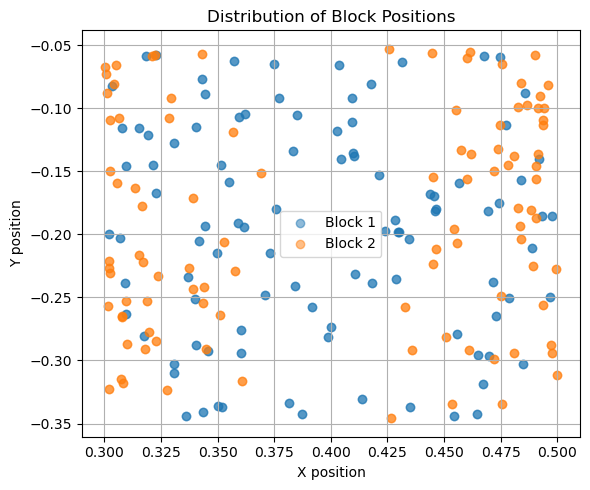

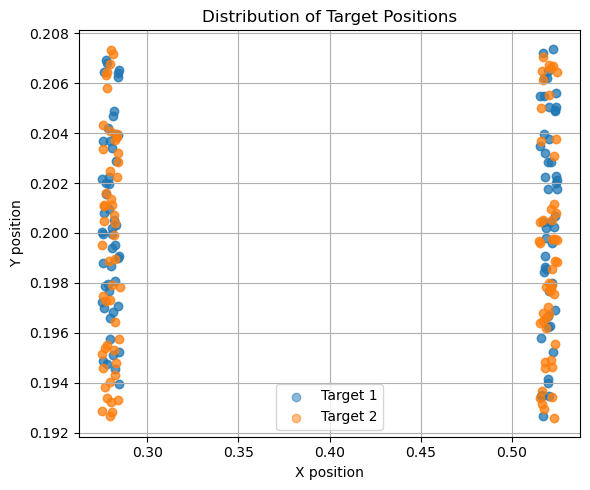

Block 1 - Mean: [ 0.39493692 -0.19604006], Std: [0.05795747 0.08438671]
Block 2 - Mean: [ 0.40200984 -0.18776542], Std: [0.07807899 0.08545087]
Target 1 - Mean: [0.39996082 0.20048122], Std: [0.12015764 0.0039594 ]
Target 2 - Mean: [0.39987433 0.19933063], Std: [0.12024939 0.00433842]


In [11]:
# Update this path to the location of your zarr dataset
dataset_path = './data/training/block_pushing/combined_push_b1t1_b1t2.zarr'

# Load dataset and compute episode boundaries
obs, episode_ends = load_zarr_dataset(dataset_path)
episode_starts = compute_episode_starts(episode_ends)
print(f"Found {len(episode_starts)} episodes in the dataset.")

# Extract initial positions for blocks and targets
block1_pos, block2_pos, target1_pos, target2_pos = extract_initial_positions(obs, episode_starts)

# Plot the distribution of block positions
plot_distribution(
    positions=[block1_pos, block2_pos],
    labels=['Block 1', 'Block 2'],
    title='Distribution of Block Positions'
)

# Plot the distribution of target positions
plot_distribution(
    positions=[target1_pos, target2_pos],
    labels=['Target 1', 'Target 2'],
    title='Distribution of Target Positions'
)

# Optionally, print summary statistics for each position
for name, pos in zip(['Block 1', 'Block 2', 'Target 1', 'Target 2'],
                     [block1_pos, block2_pos, target1_pos, target2_pos]):
    mean = np.mean(pos, axis=0)
    std = np.std(pos, axis=0)
    print(f"{name} - Mean: {mean}, Std: {std}")


Found 200 episodes in the dataset.


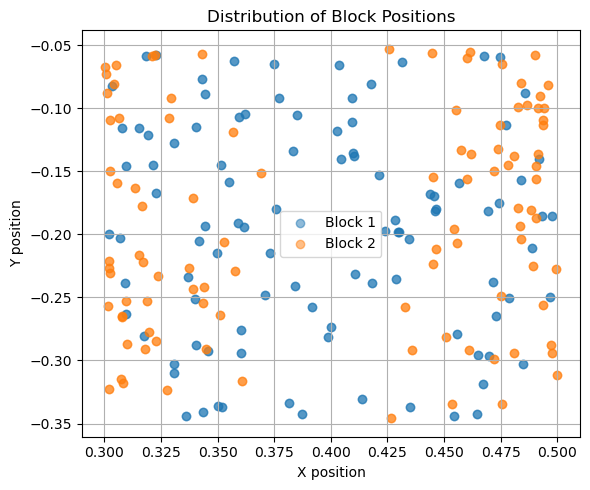

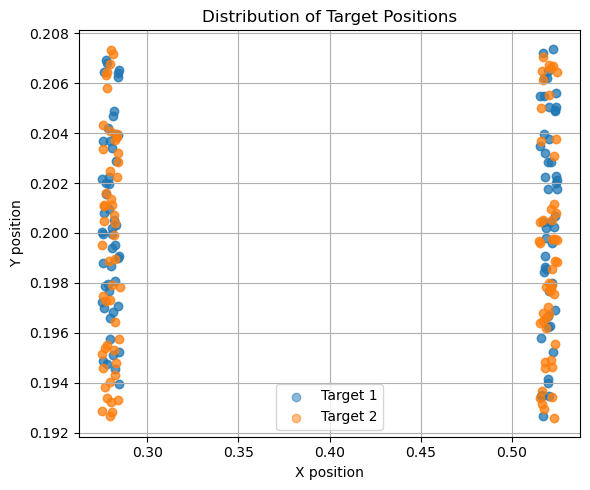

Block 1 - Mean: [ 0.39493692 -0.19604006], Std: [0.05795747 0.08438671]
Block 2 - Mean: [ 0.40200984 -0.18776542], Std: [0.07807899 0.08545086]
Target 1 - Mean: [0.39996082 0.20048122], Std: [0.12015764 0.0039594 ]
Target 2 - Mean: [0.39987433 0.19933063], Std: [0.12024939 0.00433842]


In [12]:
# Update this path to the location of your zarr dataset
dataset_path = './data/training/block_pushing/combined_push_b1t1_b2t1.zarr'

# Load dataset and compute episode boundaries
obs, episode_ends = load_zarr_dataset(dataset_path)
episode_starts = compute_episode_starts(episode_ends)
print(f"Found {len(episode_starts)} episodes in the dataset.")

# Extract initial positions for blocks and targets
block1_pos, block2_pos, target1_pos, target2_pos = extract_initial_positions(obs, episode_starts)

# Plot the distribution of block positions
plot_distribution(
    positions=[block1_pos, block2_pos],
    labels=['Block 1', 'Block 2'],
    title='Distribution of Block Positions'
)

# Plot the distribution of target positions
plot_distribution(
    positions=[target1_pos, target2_pos],
    labels=['Target 1', 'Target 2'],
    title='Distribution of Target Positions'
)

# Optionally, print summary statistics for each position
for name, pos in zip(['Block 1', 'Block 2', 'Target 1', 'Target 2'],
                     [block1_pos, block2_pos, target1_pos, target2_pos]):
    mean = np.mean(pos, axis=0)
    std = np.std(pos, axis=0)
    print(f"{name} - Mean: {mean}, Std: {std}")


Found 1000 episodes in the dataset.


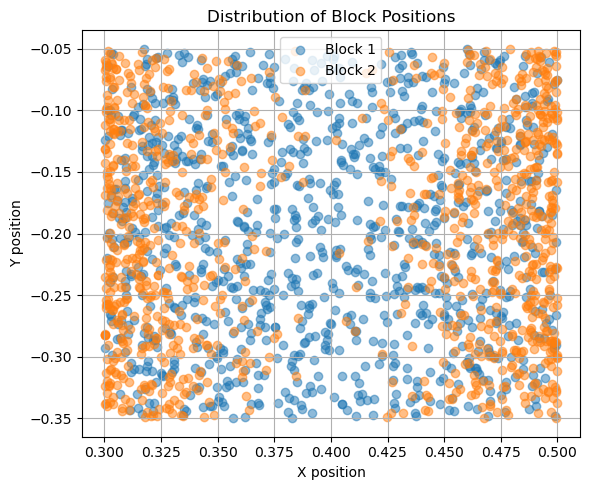

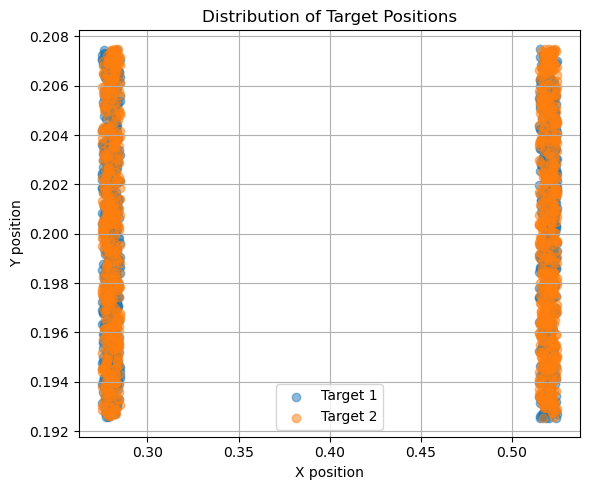

Block 1 - Mean: [ 0.39759052 -0.20006011], Std: [0.05829204 0.08496666]
Block 2 - Mean: [ 0.4022905  -0.19850452], Std: [0.07796641 0.08686355]
Target 1 - Mean: [0.39443454 0.2001011 ], Std: [0.11996392 0.00431426]
Target 2 - Mean: [0.4054842  0.20003949], Std: [0.11995067 0.00437469]


In [13]:
# Update this path to the location of your zarr dataset
dataset_path = './data/training/block_pushing/multimodal_push_seed_abs.zarr'

# Load dataset and compute episode boundaries
obs, episode_ends = load_zarr_dataset(dataset_path)
episode_starts = compute_episode_starts(episode_ends)
print(f"Found {len(episode_starts)} episodes in the dataset.")

# Extract initial positions for blocks and targets
block1_pos, block2_pos, target1_pos, target2_pos = extract_initial_positions(obs, episode_starts)

# Plot the distribution of block positions
plot_distribution(
    positions=[block1_pos, block2_pos],
    labels=['Block 1', 'Block 2'],
    title='Distribution of Block Positions'
)

# Plot the distribution of target positions
plot_distribution(
    positions=[target1_pos, target2_pos],
    labels=['Target 1', 'Target 2'],
    title='Distribution of Target Positions'
)

# Optionally, print summary statistics for each position
for name, pos in zip(['Block 1', 'Block 2', 'Target 1', 'Target 2'],
                     [block1_pos, block2_pos, target1_pos, target2_pos]):
    mean = np.mean(pos, axis=0)
    std = np.std(pos, axis=0)
    print(f"{name} - Mean: {mean}, Std: {std}")


## Plotting Starting Positions with Train/Val Splits
 This notebook loads a zarr dataset (with block pushing data) and uses the meta-data stored in `meta/episode_ends`
 along with a validation ratio to compute train/val splits. It then extracts the first observation of each episode and
 plots scatter plots for the starting positions of blocks and targets. 

In [39]:
# %% 
import os
import zarr
import numpy as np
import matplotlib.pyplot as plt
import argparse
from diffusion_policy.common.sampler import get_val_mask  # make sure this is in your PYTHONPATH

def load_zarr_dataset(dataset_path):
    # Open the zarr group in read mode.
    store = zarr.open(dataset_path, mode='r')
    # Load observations (assumed to be saved as a single numpy array under 'data/obs')
    obs = store['data/obs'][:]  # shape: (total_timesteps, obs_dim)
    # Load meta information: episode_ends contains the flattened index of the last timestep of each episode.
    episode_ends = store['meta/episode_ends'][:]
    return obs, episode_ends

def compute_episode_starts(episode_ends):
    # Compute starting indices: the first episode starts at 0; subsequent episodes start at previous end+1.
    episode_starts = []
    start = 0
    for end in episode_ends:
        episode_starts.append(start)
        start = end + 1
    return np.array(episode_starts)

def extract_initial_positions(obs, episode_starts):
    """
    Assumes each observation is a concatenated 1D vector with the following layout:
      - indices 0:2      -> block1_translation (x,y)
      - indices 3:5      -> block2_translation (x,y)
      - indices 10:12    -> target1_translation (x,y)
      - indices 13:15    -> target2_translation (x,y)
    Adjust these slices if your actual observation layout differs.
    """
    init_obs = obs[episode_starts]  # shape: (num_episodes, obs_dim)
    block1_pos = init_obs[:, 0:2]
    block2_pos = init_obs[:, 3:5]
    target1_pos = init_obs[:, 10:12]
    target2_pos = init_obs[:, 13:15]
    return block1_pos, block2_pos, target1_pos, target2_pos


In [54]:
def plot_positions_both(train_block1, train_block2, train_target1, train_target2,
                        test_block1, test_block2, test_target1, test_target2):
    # Plot block starting positions.
    plt.figure(figsize=(8,8))
    plt.scatter(train_block1[:,0], train_block1[:,1], 
                color='blue', marker='_', alpha=0.7, label='Train Block 1')
    plt.scatter(test_block1[:,0], test_block1[:,1], 
                color='blue', marker='x', alpha=0.7, label='Val Block 1')
    plt.scatter(train_block2[:,0], train_block2[:,1], 
                color='red', marker='_', alpha=0.7, label='Train Block 2')
    plt.scatter(test_block2[:,0], test_block2[:,1], 
                color='red', marker='x', alpha=0.7, label='Val Block 2')
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title("Block Starting Positions (Train vs Val)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plot target starting positions.
    plt.figure(figsize=(8,8))
    plt.scatter(train_target1[:,0], train_target1[:,1], 
                color='green', marker='|', alpha=0.7, label='Train Target 1')
    plt.scatter(test_target1[:,0], test_target1[:,1], 
                color='green', marker='x', alpha=0.7, label='Val Target 1')
    plt.scatter(train_target2[:,0], train_target2[:,1], 
                color='orange', marker='', alpha=0.7, label='Train Target 2')
    plt.scatter(test_target2[:,0], test_target2[:,1], 
                color='orange', marker='x', alpha=0.7, label='Val Target 2')
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title("Target Starting Positions (Train vs Val)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Total episodes: 1000
Train episodes: 980, val episodes: 20


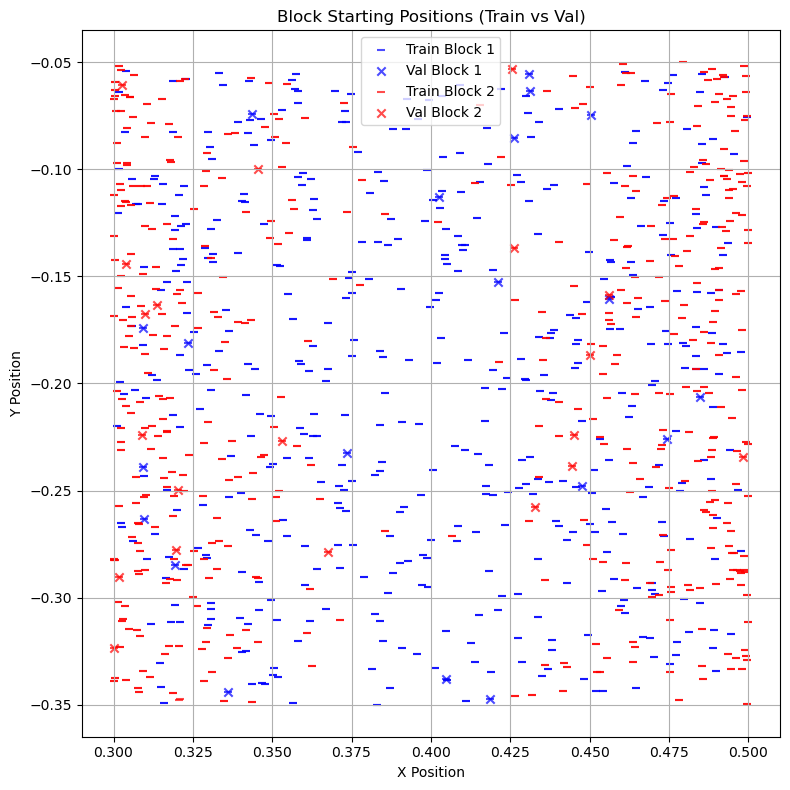

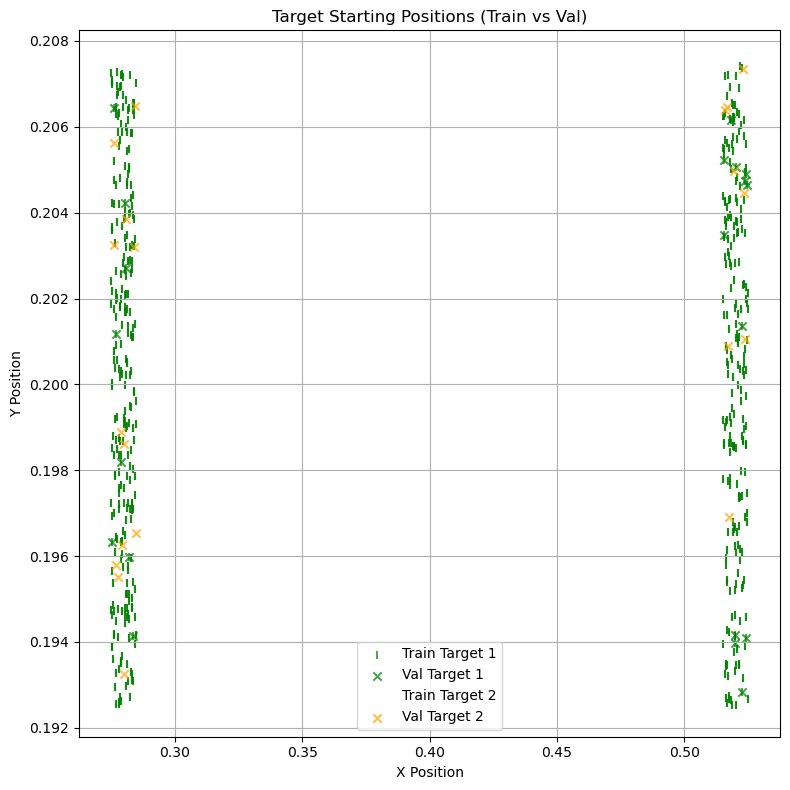

In [55]:
# For Jupyter, you can simply set these variables:
dataset_path = "data/training/block_pushing/combined_push_b1t1_b1t2_e1000.zarr"  # Change to your zarr file path
val_ratio = 0.02  # e.g. 2% of episodes are validation/val
seed = 42

# Load dataset and compute episode boundaries.
obs, episode_ends = load_zarr_dataset(dataset_path)
episode_starts = compute_episode_starts(episode_ends)
num_episodes = len(episode_starts)
print(f"Total episodes: {num_episodes}")

# Extract initial positions.
block1, block2, target1, target2 = extract_initial_positions(obs, episode_starts)

# Compute train/val split using get_val_mask.
# get_val_mask returns a Boolean mask of length num_episodes where True means the episode is in the validation (val) set.
val_mask = get_val_mask(n_episodes=num_episodes, val_ratio=val_ratio, seed=seed)
train_mask = ~val_mask

# Split positions into train and val.
block1_train = block1[train_mask]
block2_train = block2[train_mask]
target1_train = target1[train_mask]
target2_train = target2[train_mask]

block1_val = block1[val_mask]
block2_val = block2[val_mask]
target1_val = target1[val_mask]
target2_val = target2[val_mask]

print(f"Train episodes: {np.sum(train_mask)}, val episodes: {np.sum(val_mask)}")

plot_positions_both(block1_train, block2_train, target1_train, target2_train,
                    block1_val, block2_val, target1_val, target2_val)


## Visualizing Environment Initial Conditions
In our training configuration, the environment runner uses separate seeds for “train” and “test” (rollout) conditions:

- **train_start_seed**: e.g. 0, 1, 2, … (used for training rollouts)
- **test_start_seed**: e.g. 100000, 100001, … (used for evaluation rollouts)

These seeds affect how the environment (BlockPushMultimodal) is initialized (random block and target positions). The following code instantiates environments with a range of train and test seeds, resets them to get their initial observations, extracts the relevant positions, and plots them.


In [33]:
import pybullet as p
# Ensure PyBullet is connected.
if p.getConnectionInfo()['isConnected'] == 0:
    p.connect(p.DIRECT)

# %% 
import os
import numpy as np
import matplotlib.pyplot as plt
from diffusion_policy.env.block_pushing.block_pushing_multimodal import BlockPushMultimodal
from diffusion_policy.gym_util.multistep_wrapper import MultiStepWrapper
from diffusion_policy.gym_util.video_recording_wrapper import VideoRecordingWrapper, VideoRecorder
from gym.wrappers import FlattenObservation

def create_env(seed, abs_action=False):
    task_fps = 10
    max_steps = 350
    n_obs_steps = 2
    n_action_steps = 8
    fps = 5
    crf = 22
    steps_per_render = max(10 // fps, 1)
    
    # Create the base environment.
    env = BlockPushMultimodal(
        control_frequency=task_fps,
        shared_memory=False,
        seed=seed,
        abs_action=abs_action
    )
    
    # Wrap the environment: flatten the observations.
    env = FlattenObservation(env)
    
    # Add a VideoRecordingWrapper (with file output disabled).
    env = VideoRecordingWrapper(
        env,
        video_recoder=VideoRecorder.create_h264(
            fps=fps,
            codec='h264',
            input_pix_fmt='rgb24',
            crf=crf,
            thread_type='FRAME',
            thread_count=1
        ),
        file_path=None,
        steps_per_render=steps_per_render
    )
    
    # Wrap with MultiStepWrapper to mimic rollout settings.
    env = MultiStepWrapper(
        env,
        n_obs_steps=n_obs_steps,
        n_action_steps=n_action_steps,
        max_episode_steps=max_steps
    )
    return env

def extract_positions(obs):
    # If obs is 2D (n_steps, obs_dim), select the first observation.
    if obs.ndim == 2:
        obs = obs[0]
    obs = np.asarray(obs)
    
    try:
        block1 = obs[0:2]
        block2 = obs[3:5]
        target1 = obs[10:12]
        target2 = obs[13:15]
    except Exception as e:
        print("Error while slicing observation:", e)
        raise e
    return block1, block2, target1, target2


In [58]:
# Configuration values
n_train_envs = 1000
n_test_envs = 50
train_start_seed = 0
test_start_seed = 100000

# Lists to store positions.
train_block1, train_block2 = [], []
train_target1, train_target2 = [], []

test_block1, test_block2 = [], []
test_target1, test_target2 = [], []

# For train environments:
for i in range(n_train_envs):
    seed = train_start_seed + i
    env = create_env(seed)
    obs = env.reset()  # obs shape should be (2,16); we take the first row
    b1, b2, t1, t2 = extract_positions(obs)
    train_block1.append(b1)
    train_block2.append(b2)
    train_target1.append(t1)
    train_target2.append(t2)

# For test environments:
for i in range(n_test_envs):
    seed = test_start_seed + i
    env = create_env(seed)
    obs = env.reset()
    b1, b2, t1, t2 = extract_positions(obs)
    test_block1.append(b1)
    test_block2.append(b2)
    test_target1.append(t1)
    test_target2.append(t2)

# Convert lists to numpy arrays.
train_block1 = np.stack(train_block1)
train_block2 = np.stack(train_block2)
train_target1 = np.stack(train_target1)
train_target2 = np.stack(train_target2)

test_block1 = np.stack(test_block1)
test_block2 = np.stack(test_block2)
test_target1 = np.stack(test_target1)
test_target2 = np.stack(test_target2)

print("Collected train environments:", n_train_envs)
print("Collected test environments:", n_test_envs)


/home/schen964/anaconda3/envs/robodiff/lib/python3.9/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
argv[0]=
a

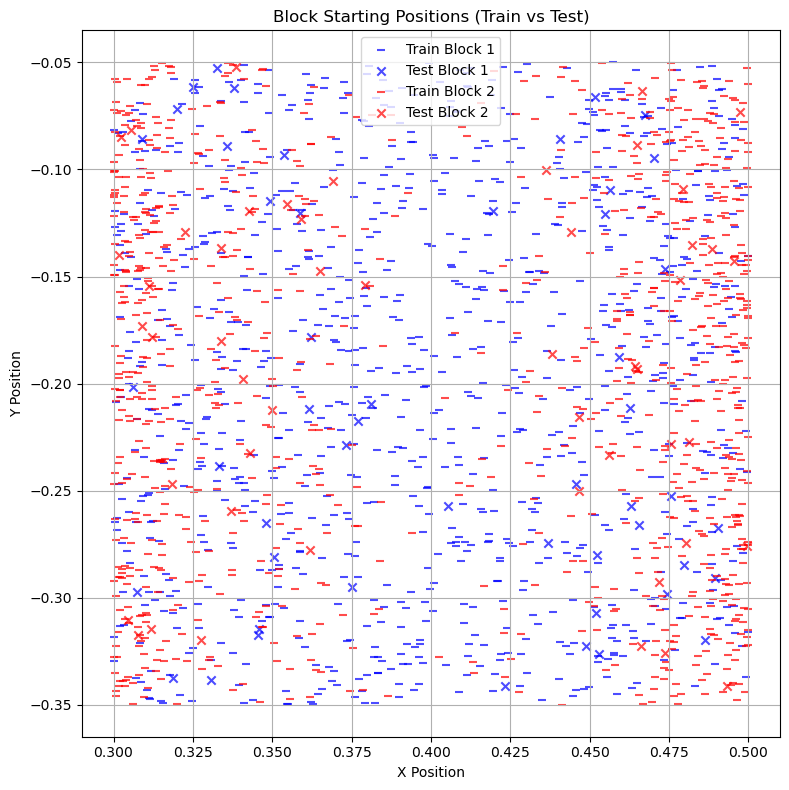

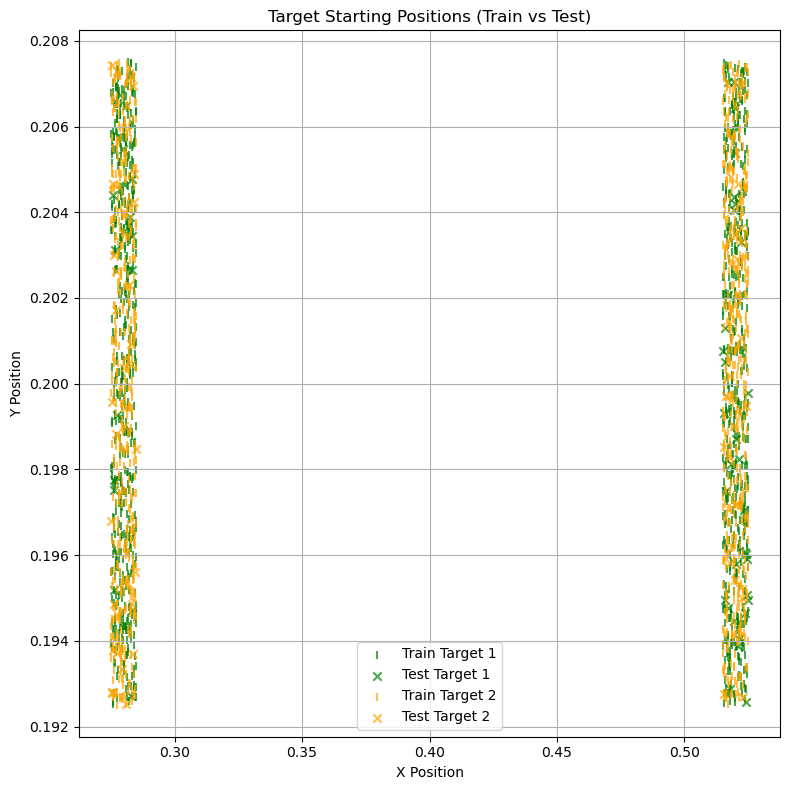

In [59]:
def plot_positions_both(train_block1, train_block2, train_target1, train_target2,
                        test_block1, test_block2, test_target1, test_target2):
    # Plot block starting positions.
    plt.figure(figsize=(8,8))
    plt.scatter(train_block1[:,0], train_block1[:,1], 
                color='blue', marker='_', alpha=0.7, label='Train Block 1')
    plt.scatter(test_block1[:,0], test_block1[:,1], 
                color='blue', marker='x', alpha=0.7, label='Test Block 1')
    plt.scatter(train_block2[:,0], train_block2[:,1], 
                color='red', marker='_', alpha=0.7, label='Train Block 2')
    plt.scatter(test_block2[:,0], test_block2[:,1], 
                color='red', marker='x', alpha=0.7, label='Test Block 2')
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title("Block Starting Positions (Train vs Test)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Plot target starting positions.
    plt.figure(figsize=(8,8))
    plt.scatter(train_target1[:,0], train_target1[:,1], 
                color='green', marker='|', alpha=0.7, label='Train Target 1')
    plt.scatter(test_target1[:,0], test_target1[:,1], 
                color='green', marker='x', alpha=0.7, label='Test Target 1')
    plt.scatter(train_target2[:,0], train_target2[:,1], 
                color='orange', marker='|', alpha=0.7, label='Train Target 2')
    plt.scatter(test_target2[:,0], test_target2[:,1], 
                color='orange', marker='x', alpha=0.7, label='Test Target 2')
    plt.xlabel("X Position")
    plt.ylabel("Y Position")
    plt.title("Target Starting Positions (Train vs Test)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# %% 
# Plot train environment positions.
plot_positions_both(train_block1, train_block2, train_target1, train_target2,
                    test_block1, test_block2, test_target1, test_target2)




In [4]:
import torch
import dill
import argparse
import pprint
import json
from omegaconf import OmegaConf

payload = torch.load(open('data/outputs/b1t1_b1t2_e2000_5000/2025.03.10/12.51.47_train_diffusion_unet_lowdim_blockpush_lowdim_seed/checkpoints/latest.ckpt', 'rb'), pickle_module=dill)

# Print the top-level keys.
print("Top-level keys in the checkpoint:")
for key in payload.keys():
    print(" -", key)

cfg = payload.get('cfg', None)
cfg_dict = OmegaConf.to_container(cfg, resolve=True)
print(json.dumps(cfg_dict, indent=4))

Top-level keys in the checkpoint:
 - cfg
 - state_dicts
 - pickles
{
    "_target_": "diffusion_policy.workspace.train_diffusion_unet_lowdim_workspace.TrainDiffusionUnetLowdimWorkspace",
    "action_dim": 2,
    "checkpoint": {
        "save_last_ckpt": true,
        "save_last_snapshot": false,
        "topk": {
            "format_str": "epoch={epoch:04d}-test_mean_score={test_mean_score:.3f}.ckpt",
            "k": 5,
            "mode": "max",
            "monitor_key": "test_mean_score"
        }
    },
    "dataloader": {
        "batch_size": 256,
        "num_workers": 1,
        "persistent_workers": false,
        "pin_memory": true,
        "shuffle": true
    },
    "ema": {
        "_target_": "diffusion_policy.model.diffusion.ema_model.EMAModel",
        "inv_gamma": 1.0,
        "max_value": 0.9999,
        "min_value": 0.0,
        "power": 0.75,
        "update_after_step": 0
    },
    "exp_name": "obs_global_rerun",
    "horizon": 12,
    "keypoint_dim": 2,
    "keyp

In [6]:
#@markdown ### **Network**
#@markdown
#@markdown Defines a 1D UNet architecture `ConditionalUnet1D`
#@markdown as the noies prediction network
#@markdown
#@markdown Components
#@markdown - `SinusoidalPosEmb` Positional encoding for the diffusion iteration k
#@markdown - `Downsample1d` Strided convolution to reduce temporal resolution
#@markdown - `Upsample1d` Transposed convolution to increase temporal resolution
#@markdown - `Conv1dBlock` Conv1d --> GroupNorm --> Mish
#@markdown - `ConditionalResidualBlock1D` Takes two inputs `x` and `cond`. \
#@markdown `x` is passed through 2 `Conv1dBlock` stacked together with residual connection.
#@markdown `cond` is applied to `x` with [FiLM](https://arxiv.org/abs/1709.07871) conditioning.

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class Downsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)

class Upsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim, 4, 2, 1)

    def forward(self, x):
        return self.conv(x)


class Conv1dBlock(nn.Module):
    '''
        Conv1d --> GroupNorm --> Mish
    '''

    def __init__(self, inp_channels, out_channels, kernel_size, n_groups=8):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv1d(inp_channels, out_channels, kernel_size, padding=kernel_size // 2),
            nn.GroupNorm(n_groups, out_channels),
            nn.Mish(),
        )

    def forward(self, x):
        return self.block(x)


class ConditionalResidualBlock1D(nn.Module):
    def __init__(self,
            in_channels,
            out_channels,
            cond_dim,
            kernel_size=3,
            n_groups=8):
        super().__init__()

        self.blocks = nn.ModuleList([
            Conv1dBlock(in_channels, out_channels, kernel_size, n_groups=n_groups),
            Conv1dBlock(out_channels, out_channels, kernel_size, n_groups=n_groups),
        ])

        # FiLM modulation https://arxiv.org/abs/1709.07871
        # predicts per-channel scale and bias
        cond_channels = out_channels * 2
        self.out_channels = out_channels
        self.cond_encoder = nn.Sequential(
            nn.Mish(),
            nn.Linear(cond_dim, cond_channels),
            nn.Unflatten(-1, (-1, 1))
        )

        # make sure dimensions compatible
        self.residual_conv = nn.Conv1d(in_channels, out_channels, 1) \
            if in_channels != out_channels else nn.Identity()

    def forward(self, x, cond):
        '''
            x : [ batch_size x in_channels x horizon ]
            cond : [ batch_size x cond_dim]

            returns:
            out : [ batch_size x out_channels x horizon ]
        '''
        out = self.blocks[0](x)
        embed = self.cond_encoder(cond)

        embed = embed.reshape(
            embed.shape[0], 2, self.out_channels, 1)
        scale = embed[:,0,...]
        bias = embed[:,1,...]
        out = scale * out + bias

        out = self.blocks[1](out)
        out = out + self.residual_conv(x)
        return out


class ConditionalUnet1D(nn.Module):
    def __init__(self,
        input_dim,
        global_cond_dim,
        diffusion_step_embed_dim=256,
        down_dims=[256,512,1024],
        kernel_size=5,
        n_groups=8
        ):
        """
        input_dim: Dim of actions.
        global_cond_dim: Dim of global conditioning applied with FiLM
          in addition to diffusion step embedding. This is usually obs_horizon * obs_dim
        diffusion_step_embed_dim: Size of positional encoding for diffusion iteration k
        down_dims: Channel size for each UNet level.
          The length of this array determines numebr of levels.
        kernel_size: Conv kernel size
        n_groups: Number of groups for GroupNorm
        """

        super().__init__()
        all_dims = [input_dim] + list(down_dims)
        start_dim = down_dims[0]

        dsed = diffusion_step_embed_dim
        diffusion_step_encoder = nn.Sequential(
            SinusoidalPosEmb(dsed),
            nn.Linear(dsed, dsed * 4),
            nn.Mish(),
            nn.Linear(dsed * 4, dsed),
        )
        cond_dim = dsed + global_cond_dim

        in_out = list(zip(all_dims[:-1], all_dims[1:]))
        mid_dim = all_dims[-1]
        self.mid_modules = nn.ModuleList([
            ConditionalResidualBlock1D(
                mid_dim, mid_dim, cond_dim=cond_dim,
                kernel_size=kernel_size, n_groups=n_groups
            ),
            ConditionalResidualBlock1D(
                mid_dim, mid_dim, cond_dim=cond_dim,
                kernel_size=kernel_size, n_groups=n_groups
            ),
        ])

        down_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (len(in_out) - 1)
            down_modules.append(nn.ModuleList([
                ConditionalResidualBlock1D(
                    dim_in, dim_out, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                ConditionalResidualBlock1D(
                    dim_out, dim_out, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                Downsample1d(dim_out) if not is_last else nn.Identity()
            ]))

        up_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (len(in_out) - 1)
            up_modules.append(nn.ModuleList([
                ConditionalResidualBlock1D(
                    dim_out*2, dim_in, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                ConditionalResidualBlock1D(
                    dim_in, dim_in, cond_dim=cond_dim,
                    kernel_size=kernel_size, n_groups=n_groups),
                Upsample1d(dim_in) if not is_last else nn.Identity()
            ]))

        final_conv = nn.Sequential(
            Conv1dBlock(start_dim, start_dim, kernel_size=kernel_size),
            nn.Conv1d(start_dim, input_dim, 1),
        )

        self.diffusion_step_encoder = diffusion_step_encoder
        self.up_modules = up_modules
        self.down_modules = down_modules
        self.final_conv = final_conv

        print("number of parameters: {:e}".format(
            sum(p.numel() for p in self.parameters()))
        )

    def forward(self,
            sample: torch.Tensor,
            timestep: Union[torch.Tensor, float, int],
            global_cond=None):
        """
        x: (B,T,input_dim)
        timestep: (B,) or int, diffusion step
        global_cond: (B,global_cond_dim)
        output: (B,T,input_dim)
        """
        # (B,T,C)
        sample = sample.moveaxis(-1,-2)
        # (B,C,T)

        # 1. time
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            # TODO: this requires sync between CPU and GPU. So try to pass timesteps as tensors if you can
            timesteps = torch.tensor([timesteps], dtype=torch.long, device=sample.device)
        elif torch.is_tensor(timesteps) and len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)
        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        timesteps = timesteps.expand(sample.shape[0])

        global_feature = self.diffusion_step_encoder(timesteps)

        if global_cond is not None:
            global_feature = torch.cat([
                global_feature, global_cond
            ], axis=-1)

        x = sample
        h = []
        for idx, (resnet, resnet2, downsample) in enumerate(self.down_modules):
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            h.append(x)
            x = downsample(x)

        for mid_module in self.mid_modules:
            x = mid_module(x, global_feature)

        for idx, (resnet, resnet2, upsample) in enumerate(self.up_modules):
            x = torch.cat((x, h.pop()), dim=1)
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            x = upsample(x)

        x = self.final_conv(x)

        # (B,C,T)
        x = x.moveaxis(-1,-2)
        # (B,T,C)
        return x


In [9]:
#@markdown ### **Network Demo**

# observation and action dimensions corrsponding to
# the output of PushTEnv
# obs_dim = 5
obs_dim = 16
action_dim = 2

# create network object
noise_pred_net = ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim*obs_horizon
)

# example inputs
noised_action = torch.randn((1, pred_horizon, action_dim))
obs = torch.zeros((1, obs_horizon, obs_dim))
diffusion_iter = torch.zeros((1,))

# the noise prediction network
# takes noisy action, diffusion iteration and observation as input
# predicts the noise added to action
noise = noise_pred_net(
    sample=noised_action,
    timestep=diffusion_iter,
    global_cond=obs.flatten(start_dim=1))

# illustration of removing noise
# the actual noise removal is performed by NoiseScheduler
# and is dependent on the diffusion noise schedule
denoised_action = noised_action - noise

# for this demo, we use DDPMScheduler with 100 diffusion iterations
num_diffusion_iters = 100
noise_scheduler = DDPMScheduler(
    num_train_timesteps=num_diffusion_iters,
    # the choise of beta schedule has big impact on performance
    # we found squared cosine works the best
    beta_schedule='squaredcos_cap_v2',
    # clip output to [-1,1] to improve stability
    clip_sample=True,
    # our network predicts noise (instead of denoised action)
    prediction_type='epsilon'
)

# device transfer
device = torch.device('cuda')
_ = noise_pred_net.to(device)

number of parameters: 6.566861e+07


In [13]:
#@markdown ### **Training**
#@markdown
#@markdown Takes about an hour. If you don't want to wait, skip to the next cell
#@markdown to load pre-trained weights

num_epochs = 100

# Exponential Moving Average
# accelerates training and improves stability
# holds a copy of the model weights
ema = EMAModel(
    parameters=noise_pred_net.parameters(),
    power=0.75)

# Standard ADAM optimizer
# Note that EMA parametesr are not optimized
optimizer = torch.optim.AdamW(
    params=noise_pred_net.parameters(),
    lr=1e-4, weight_decay=1e-6)

# Cosine LR schedule with linear warmup
lr_scheduler = get_scheduler(
    name='cosine',
    optimizer=optimizer,
    num_warmup_steps=500,
    num_training_steps=len(dataloader) * num_epochs
)

with tqdm(range(num_epochs), desc='Epoch') as tglobal:
    # epoch loop
    for epoch_idx in tglobal:
        epoch_loss = list()
        # batch loop
        with tqdm(dataloader, desc='Batch', leave=False) as tepoch:
            for nbatch in tepoch:
                # data normalized in dataset
                # device transfer
                nobs = nbatch['obs'].to(device)
                naction = nbatch['action'].to(device)
                B = nobs.shape[0]

                # observation as FiLM conditioning
                # (B, obs_horizon, obs_dim)
                obs_cond = nobs[:,:obs_horizon,:]
                # (B, obs_horizon * obs_dim)
                obs_cond = obs_cond.flatten(start_dim=1)

                # sample noise to add to actions
                noise = torch.randn(naction.shape, device=device)

                # sample a diffusion iteration for each data point
                timesteps = torch.randint(
                    0, noise_scheduler.config.num_train_timesteps,
                    (B,), device=device
                ).long()

                # add noise to the clean images according to the noise magnitude at each diffusion iteration
                # (this is the forward diffusion process)
                noisy_actions = noise_scheduler.add_noise(
                    naction, noise, timesteps)

                # predict the noise residual
                noise_pred = noise_pred_net(
                    noisy_actions, timesteps, global_cond=obs_cond)

                # L2 loss
                loss = nn.functional.mse_loss(noise_pred, noise)

                # optimize
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                # step lr scheduler every batch
                # this is different from standard pytorch behavior
                lr_scheduler.step()

                # update Exponential Moving Average of the model weights
                ema.step(noise_pred_net.parameters())

                # logging
                loss_cpu = loss.item()
                epoch_loss.append(loss_cpu)
                tepoch.set_postfix(loss=loss_cpu)
        tglobal.set_postfix(loss=np.mean(epoch_loss))

# Weights of the EMA model
# is used for inference
ema_noise_pred_net = noise_pred_net
ema.copy_to(ema_noise_pred_net.parameters())

Epoch:   1%|          | 1/100 [00:59<1:37:54, 59.34s/it, loss=0.0598]


KeyboardInterrupt: 

In [ ]:
# Training code for two separate models
num_epochs = 100

# Training for model 1
ema1 = EMAModel(parameters=noise_pred_net.parameters(), power=0.75)
optimizer1 = torch.optim.AdamW(params=noise_pred_net.parameters(), lr=1e-4, weight_decay=1e-6)
lr_scheduler1 = get_scheduler(
    name='cosine',
    optimizer=optimizer1,
    num_warmup_steps=500,
    num_training_steps=len(filtered_dataloader1) * num_epochs
)

with tqdm(range(num_epochs), desc='Model 1 Training Epoch') as tglobal:
    for epoch_idx in tglobal:
        epoch_loss = list()
        with tqdm(filtered_dataloader1, desc='Batch', leave=False) as tepoch:
            for nbatch in tepoch:
                nobs = nbatch['obs'].to(device)
                naction = nbatch['action'].to(device)
                B = nobs.shape[0]
                obs_cond = nobs[:, :obs_horizon, :].flatten(start_dim=1)
                noise = torch.randn(naction.shape, device=device)
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (B,), device=device).long()
                noisy_actions = noise_scheduler.add_noise(naction, noise, timesteps)
                noise_pred = noise_pred_net(noisy_actions, timesteps, global_cond=obs_cond)
                loss = nn.functional.mse_loss(noise_pred, noise)
                loss.backward()
                optimizer1.step()
                optimizer1.zero_grad()
                lr_scheduler1.step()
                ema1.step(noise_pred_net.parameters())
                loss_cpu = loss.item()
                epoch_loss.append(loss_cpu)
                tepoch.set_postfix(loss=loss_cpu)
        tglobal.set_postfix(loss=np.mean(epoch_loss))

# Training for model 2
ema2 = EMAModel(parameters=noise_pred_net.parameters(), power=0.75)
optimizer2 = torch.optim.AdamW(params=noise_pred_net.parameters(), lr=1e-4, weight_decay=1e-6)
lr_scheduler2 = get_scheduler(
    name='cosine',
    optimizer=optimizer2,
    num_warmup_steps=500,
    num_training_steps=len(filtered_dataloader2) * num_epochs
)

with tqdm(range(num_epochs), desc='Model 2 Training Epoch') as tglobal:
    for epoch_idx in tglobal:
        epoch_loss = list()
        with tqdm(filtered_dataloader2, desc='Batch', leave=False) as tepoch:
            for nbatch in tepoch:
                nobs = nbatch['obs'].to(device)
                naction = nbatch['action'].to(device)
                B = nobs.shape[0]
                obs_cond = nobs[:, :obs_horizon, :].flatten(start_dim=1)
                noise = torch.randn(naction.shape, device=device)
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (B,), device=device).long()
                noisy_actions = noise_scheduler.add_noise(naction, noise, timesteps)
                noise_pred = noise_pred_net(noisy_actions, timesteps, global_cond=obs_cond)
                loss = nn.functional.mse_loss(noise_pred, noise)
                loss.backward()
                optimizer2.step()
                optimizer2.zero_grad()
                lr_scheduler2.step()
                ema2.step(noise_pred_net.parameters())
                loss_cpu = loss.item()
                epoch_loss.append(loss_cpu)
                tepoch.set_postfix(loss=loss_cpu)
        tglobal.set_postfix(loss=np.mean(epoch_loss))

# Weights of the EMA model are used for inference
ema_noise_pred_net1 = noise_pred_net
ema1.copy_to(ema_noise_pred_net1.parameters())

ema_noise_pred_net2 = noise_pred_net
ema2.copy_to(ema_noise_pred_net2.parameters())

print("Training of both models completed.")


In [16]:
#@markdown ### **Loading Pretrained Checkpoint**
#@markdown Set `load_pretrained = True` to load pretrained weights.

load_pretrained = True
if load_pretrained:
  # ckpt_path = "pusht_state_100ep.ckpt"
  ckpt_path = "data/experiments/low_dim/block_pushing/diffusion_policy_cnn/train_0/checkpoints/latest.ckpt"
  # if not os.path.isfile(ckpt_path):
      # id = "1mHDr_DEZSdiGo9yecL50BBQYzR8Fjhl_&confirm=t"
      # gdown.download(id=id, output=ckpt_path, quiet=False)

  # state_dict = torch.load(ckpt_path, map_location='cuda')
  state_dict = torch.load(ckpt_path, map_location='cuda', weights_only=False)
  ema_noise_pred_net = noise_pred_net
  ema_noise_pred_net.load_state_dict(state_dict)
  print('Pretrained weights loaded.')
else:
  print("Skipped pretrained weight loading.")

RuntimeError: Error(s) in loading state_dict for ConditionalUnet1D:
	Missing key(s) in state_dict: "mid_modules.0.blocks.0.block.0.weight", "mid_modules.0.blocks.0.block.0.bias", "mid_modules.0.blocks.0.block.1.weight", "mid_modules.0.blocks.0.block.1.bias", "mid_modules.0.blocks.1.block.0.weight", "mid_modules.0.blocks.1.block.0.bias", "mid_modules.0.blocks.1.block.1.weight", "mid_modules.0.blocks.1.block.1.bias", "mid_modules.0.cond_encoder.1.weight", "mid_modules.0.cond_encoder.1.bias", "mid_modules.1.blocks.0.block.0.weight", "mid_modules.1.blocks.0.block.0.bias", "mid_modules.1.blocks.0.block.1.weight", "mid_modules.1.blocks.0.block.1.bias", "mid_modules.1.blocks.1.block.0.weight", "mid_modules.1.blocks.1.block.0.bias", "mid_modules.1.blocks.1.block.1.weight", "mid_modules.1.blocks.1.block.1.bias", "mid_modules.1.cond_encoder.1.weight", "mid_modules.1.cond_encoder.1.bias", "diffusion_step_encoder.1.weight", "diffusion_step_encoder.1.bias", "diffusion_step_encoder.3.weight", "diffusion_step_encoder.3.bias", "up_modules.0.0.blocks.0.block.0.weight", "up_modules.0.0.blocks.0.block.0.bias", "up_modules.0.0.blocks.0.block.1.weight", "up_modules.0.0.blocks.0.block.1.bias", "up_modules.0.0.blocks.1.block.0.weight", "up_modules.0.0.blocks.1.block.0.bias", "up_modules.0.0.blocks.1.block.1.weight", "up_modules.0.0.blocks.1.block.1.bias", "up_modules.0.0.cond_encoder.1.weight", "up_modules.0.0.cond_encoder.1.bias", "up_modules.0.0.residual_conv.weight", "up_modules.0.0.residual_conv.bias", "up_modules.0.1.blocks.0.block.0.weight", "up_modules.0.1.blocks.0.block.0.bias", "up_modules.0.1.blocks.0.block.1.weight", "up_modules.0.1.blocks.0.block.1.bias", "up_modules.0.1.blocks.1.block.0.weight", "up_modules.0.1.blocks.1.block.0.bias", "up_modules.0.1.blocks.1.block.1.weight", "up_modules.0.1.blocks.1.block.1.bias", "up_modules.0.1.cond_encoder.1.weight", "up_modules.0.1.cond_encoder.1.bias", "up_modules.0.2.conv.weight", "up_modules.0.2.conv.bias", "up_modules.1.0.blocks.0.block.0.weight", "up_modules.1.0.blocks.0.block.0.bias", "up_modules.1.0.blocks.0.block.1.weight", "up_modules.1.0.blocks.0.block.1.bias", "up_modules.1.0.blocks.1.block.0.weight", "up_modules.1.0.blocks.1.block.0.bias", "up_modules.1.0.blocks.1.block.1.weight", "up_modules.1.0.blocks.1.block.1.bias", "up_modules.1.0.cond_encoder.1.weight", "up_modules.1.0.cond_encoder.1.bias", "up_modules.1.0.residual_conv.weight", "up_modules.1.0.residual_conv.bias", "up_modules.1.1.blocks.0.block.0.weight", "up_modules.1.1.blocks.0.block.0.bias", "up_modules.1.1.blocks.0.block.1.weight", "up_modules.1.1.blocks.0.block.1.bias", "up_modules.1.1.blocks.1.block.0.weight", "up_modules.1.1.blocks.1.block.0.bias", "up_modules.1.1.blocks.1.block.1.weight", "up_modules.1.1.blocks.1.block.1.bias", "up_modules.1.1.cond_encoder.1.weight", "up_modules.1.1.cond_encoder.1.bias", "up_modules.1.2.conv.weight", "up_modules.1.2.conv.bias", "down_modules.0.0.blocks.0.block.0.weight", "down_modules.0.0.blocks.0.block.0.bias", "down_modules.0.0.blocks.0.block.1.weight", "down_modules.0.0.blocks.0.block.1.bias", "down_modules.0.0.blocks.1.block.0.weight", "down_modules.0.0.blocks.1.block.0.bias", "down_modules.0.0.blocks.1.block.1.weight", "down_modules.0.0.blocks.1.block.1.bias", "down_modules.0.0.cond_encoder.1.weight", "down_modules.0.0.cond_encoder.1.bias", "down_modules.0.0.residual_conv.weight", "down_modules.0.0.residual_conv.bias", "down_modules.0.1.blocks.0.block.0.weight", "down_modules.0.1.blocks.0.block.0.bias", "down_modules.0.1.blocks.0.block.1.weight", "down_modules.0.1.blocks.0.block.1.bias", "down_modules.0.1.blocks.1.block.0.weight", "down_modules.0.1.blocks.1.block.0.bias", "down_modules.0.1.blocks.1.block.1.weight", "down_modules.0.1.blocks.1.block.1.bias", "down_modules.0.1.cond_encoder.1.weight", "down_modules.0.1.cond_encoder.1.bias", "down_modules.0.2.conv.weight", "down_modules.0.2.conv.bias", "down_modules.1.0.blocks.0.block.0.weight", "down_modules.1.0.blocks.0.block.0.bias", "down_modules.1.0.blocks.0.block.1.weight", "down_modules.1.0.blocks.0.block.1.bias", "down_modules.1.0.blocks.1.block.0.weight", "down_modules.1.0.blocks.1.block.0.bias", "down_modules.1.0.blocks.1.block.1.weight", "down_modules.1.0.blocks.1.block.1.bias", "down_modules.1.0.cond_encoder.1.weight", "down_modules.1.0.cond_encoder.1.bias", "down_modules.1.0.residual_conv.weight", "down_modules.1.0.residual_conv.bias", "down_modules.1.1.blocks.0.block.0.weight", "down_modules.1.1.blocks.0.block.0.bias", "down_modules.1.1.blocks.0.block.1.weight", "down_modules.1.1.blocks.0.block.1.bias", "down_modules.1.1.blocks.1.block.0.weight", "down_modules.1.1.blocks.1.block.0.bias", "down_modules.1.1.blocks.1.block.1.weight", "down_modules.1.1.blocks.1.block.1.bias", "down_modules.1.1.cond_encoder.1.weight", "down_modules.1.1.cond_encoder.1.bias", "down_modules.1.2.conv.weight", "down_modules.1.2.conv.bias", "down_modules.2.0.blocks.0.block.0.weight", "down_modules.2.0.blocks.0.block.0.bias", "down_modules.2.0.blocks.0.block.1.weight", "down_modules.2.0.blocks.0.block.1.bias", "down_modules.2.0.blocks.1.block.0.weight", "down_modules.2.0.blocks.1.block.0.bias", "down_modules.2.0.blocks.1.block.1.weight", "down_modules.2.0.blocks.1.block.1.bias", "down_modules.2.0.cond_encoder.1.weight", "down_modules.2.0.cond_encoder.1.bias", "down_modules.2.0.residual_conv.weight", "down_modules.2.0.residual_conv.bias", "down_modules.2.1.blocks.0.block.0.weight", "down_modules.2.1.blocks.0.block.0.bias", "down_modules.2.1.blocks.0.block.1.weight", "down_modules.2.1.blocks.0.block.1.bias", "down_modules.2.1.blocks.1.block.0.weight", "down_modules.2.1.blocks.1.block.0.bias", "down_modules.2.1.blocks.1.block.1.weight", "down_modules.2.1.blocks.1.block.1.bias", "down_modules.2.1.cond_encoder.1.weight", "down_modules.2.1.cond_encoder.1.bias", "final_conv.0.block.0.weight", "final_conv.0.block.0.bias", "final_conv.0.block.1.weight", "final_conv.0.block.1.bias", "final_conv.1.weight", "final_conv.1.bias". 
	Unexpected key(s) in state_dict: "cfg", "state_dicts", "pickles". 

In [ ]:
import dill
import hydra
from diffusion_policy.workspace.base_workspace import BaseWorkspace

# load checkpoint
ckpt_path = "data/experiments/low_dim/block_pushing/diffusion_policy_cnn/train_2/checkpoints/latest.ckpt"
output_dir = "data/trash"
payload = torch.load(open(ckpt_path, 'rb'), pickle_module=dill) 
cfg = payload['cfg']
cls = hydra.utils.get_class(cfg._target_)
workspace = cls(cfg, output_dir=output_dir)
workspace: BaseWorkspace
workspace.load_payload(payload, exclude_keys=None, include_keys=None)


# get policy from workspace
policy = workspace.model
if cfg.training.use_ema:
    policy = workspace.ema_model

device = torch.device(device)
policy.to(device)
policy.eval()


2024-11-15 15:40:30,008 [INFO] number of parameters: 6.566861e+07


DiffusionUnetLowdimPolicy(
  (model): ConditionalUnet1D(
    (mid_modules): ModuleList(
      (0-1): 2 x ConditionalResidualBlock1D(
        (blocks): ModuleList(
          (0-1): 2 x Conv1dBlock(
            (block): Sequential(
              (0): Conv1d(1024, 1024, kernel_size=(5,), stride=(1,), padding=(2,))
              (1): GroupNorm(8, 1024, eps=1e-05, affine=True)
              (2): Mish()
            )
          )
        )
        (cond_encoder): Sequential(
          (0): Mish()
          (1): Linear(in_features=288, out_features=2048, bias=True)
          (2): Rearrange('batch t -> batch t 1')
        )
        (residual_conv): Identity()
      )
    )
    (diffusion_step_encoder): Sequential(
      (0): SinusoidalPosEmb()
      (1): Linear(in_features=256, out_features=1024, bias=True)
      (2): Mish()
      (3): Linear(in_features=1024, out_features=256, bias=True)
    )
    (up_modules): ModuleList(
      (0): ModuleList(
        (0): ConditionalResidualBlock1D(
       

In [11]:
#@markdown ### **Inference**

from typing import Dict, Callable, List
# limit enviornment interaction to 200 steps before termination
max_steps = 200
# env = PushTEnv()
env = BlockPushMultimodal()
# use a seed >200 to avoid initial states seen in the training dataset
env.seed(100000)

# get first observation
obs = env.reset()

policy.reset()

# keep a queue of last 2 steps of observations
obs_deque = collections.deque(
    [obs] * obs_horizon, maxlen=obs_horizon)
# save visualization and rewards
imgs = [env.render(mode='rgb_array')]
rewards = list()
done = False
step_idx = 0


def dict_apply(
        x: Dict[str, torch.Tensor], 
        func: Callable[[torch.Tensor], torch.Tensor]
        ) -> Dict[str, torch.Tensor]:
    result = dict()
    for key, value in x.items():
        if isinstance(value, dict):
            result[key] = dict_apply(value, func)
        else:
            result[key] = func(value)
    return result

# with tqdm(total=max_steps, desc="Eval PushTStateEnv") as pbar:
with tqdm(total=max_steps, desc="Eval BlockPushLowdim") as pbar:
    while not done:
        with torch.no_grad():
            np_obs_dict = {
                'obs': obs.astype(np.float32)
            }
            # device transfer
            obs_dict = dict_apply(np_obs_dict, 
                lambda x: torch.from_numpy(x).to(
                device=device))
            action_dict = policy.predict_action(obs_dict)
        # B = 1
        # # stack the last obs_horizon (2) number of observations
        # obs_seq = np.stack(obs_deque)
        # # normalize observation
        # nobs = normalize_data(obs_seq, stats=stats['obs'])
        # # device transfer
        # nobs = torch.from_numpy(nobs).to(device, dtype=torch.float32)

        # # infer action
        # with torch.no_grad():
        #     # reshape observation to (B,obs_horizon*obs_dim)
        #     obs_cond = nobs.unsqueeze(0).flatten(start_dim=1)

        #     # initialize action from Guassian noise
        #     noisy_action = torch.randn(
        #         (B, pred_horizon, action_dim), device=device)
        #     naction = noisy_action

        #     # init scheduler
        #     noise_scheduler.set_timesteps(num_diffusion_iters)

        #     for k in noise_scheduler.timesteps:
        #         # predict noise
        #         noise_pred = ema_noise_pred_net(
        #             sample=naction,
        #             timestep=k,
        #             global_cond=obs_cond
        #         )

        #         # inverse diffusion step (remove noise)
        #         naction = noise_scheduler.step(
        #             model_output=noise_pred,
        #             timestep=k,
        #             sample=naction
        #         ).prev_sample

        # unnormalize action
        naction = naction.detach().to('cpu').numpy()
        # (B, pred_horizon, action_dim)
        naction = naction[0]
        action_pred = unnormalize_data(naction, stats=stats['action'])

        # only take action_horizon number of actions
        start = obs_horizon - 1
        end = start + action_horizon
        action = action_pred[start:end,:]
        # (action_horizon, action_dim)

        # execute action_horizon number of steps
        # without replanning
        for i in range(len(action)):
            # stepping env
            obs, reward, done, _, info = env.step(action[i])
            # save observations
            obs_deque.append(obs)
            # and reward/vis
            rewards.append(reward)
            imgs.append(env.render(mode='rgb_array'))

            # update progress bar
            step_idx += 1
            pbar.update(1)
            pbar.set_postfix(reward=reward)
            if step_idx > max_steps:
                done = True
            if done:
                break

# print out the maximum target coverage
print('Score: ', max(rewards))

# visualize
from IPython.display import Video
vwrite('vis.mp4', imgs)
Video('vis.mp4', embed=True, width=256, height=256)

/home/sfchen/miniforge3/envs/robodiff/lib/python3.9/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


argv[0]=


Eval BlockPushLowdim:   0%|          | 0/200 [00:00<?, ?it/s]


AttributeError: 'collections.OrderedDict' object has no attribute 'astype'

In [18]:
m = []
sum_n, sum_d = 0, 0
for d in [0.6, 0.4]:
    for s in [0.7, 0.3]:
        if d == 0.6 and s == 0.7:
            m = [0.7, 0.3]
        elif d == 0.6 and s == 0.3:
            m = [0.4, 0.6]
        elif d == 0.4 and s == 0.7:
            m = [0.5, 0.5]
        elif d == 0.4 and s == 0.3:
            m = [0.2, 0.8]
        
        
        for i in range(len(m)):
            if d == 0.6 and i == 0:
                r = 0.3
                a = 0.2
                p = 0.4
            elif d == 0.6 and i == 1:
                r = 0.4
                a = 0.6
                p = 0.7
            elif d == 0.4 and 1 == 0:
                r = 0.5
                a = 0.2
                p = 0.4
            elif d == 0.4 and i == 1:
                r = 0.6
                a = 0.6
                p = 0.7
            
            for c in [0.5, 0.5]:
                sum_n += d * s * m[i] * r * p * a * c

for d in [0.6, 0.4]:
    for s in [0.7, 0.3]:
        if d == 0.6 and s == 0.7:
            m = [0.7, 0.3]
        elif d == 0.6 and s == 0.3:
            m = [0.4, 0.6]
        elif d == 0.4 and s == 0.7:
            m = [0.5, 0.5]
        elif d == 0.4 and s == 0.3:
            m = [0.2, 0.8]
        
        
        for i in range(len(m)):
            if d == 0.6 and i == 0:
                r = 0.3
                a = 0.2
                p = [0.6, 0.4]
            elif d == 0.6 and i == 1:
                r = 0.4
                a = 0.6
                p = [0.3, 0.7]
            elif d == 0.4 and 1 == 0:
                r = 0.5
                a = 0.2
                p = [0.6, 0.4]
            elif d == 0.4 and i == 1:
                r = 0.6
                a = 0.6
                p = [0.3, 0.7]
            
            for j in range(len(p)):
                if j == 0:
                    c = [0.7, 0.3]
                elif j == 1:
                    c = [0.5, 0.5]
                for k in range(len(c)):
                    sum_d += d * s * m[i] * r * p[j] * a * c[k]
           

0.6679135008766803
2347 3514
0.6678998292544109
5861
2348 3515
0.6679943100995732
5863


In [2]:
from fractions import Fraction

# Initialize variables
sum_n, sum_d = Fraction(0), Fraction(0)

# Loop through d and s values
for d in [Fraction(6, 10), Fraction(4, 10)]:
    for s in [Fraction(7, 10), Fraction(3, 10)]:
        # Set m values
        if d == Fraction(6, 10) and s == Fraction(7, 10):
            m = [Fraction(7, 10), Fraction(3, 10)]
        elif d == Fraction(6, 10) and s == Fraction(3, 10):
            m = [Fraction(4, 10), Fraction(6, 10)]
        elif d == Fraction(4, 10) and s == Fraction(7, 10):
            m = [Fraction(5, 10), Fraction(5, 10)]
        elif d == Fraction(4, 10) and s == Fraction(3, 10):
            m = [Fraction(2, 10), Fraction(8, 10)]

        # Iterate over m values
        for i in range(len(m)):
            # Set r, a, p values
            if d == Fraction(6, 10) and i == 0:
                r, a, p = Fraction(3, 10), Fraction(2, 10), Fraction(4, 10)
            elif d == Fraction(6, 10) and i == 1:
                r, a, p = Fraction(4, 10), Fraction(6, 10), Fraction(7, 10)
            elif d == Fraction(4, 10) and i == 0:
                r, a, p = Fraction(5, 10), Fraction(2, 10), Fraction(4, 10)
            elif d == Fraction(4, 10) and i == 1:
                r, a, p = Fraction(6, 10), Fraction(6, 10), Fraction(7, 10)

            # Iterate over c values
            for c in [Fraction(5, 10), Fraction(5, 10)]:
                sum_n += d * s * m[i] * r * p * a * c

# Loop again for second sum (sum_d)
for d in [Fraction(6, 10), Fraction(4, 10)]:
    for s in [Fraction(7, 10), Fraction(3, 10)]:
        # Set m values
        if d == Fraction(6, 10) and s == Fraction(7, 10):
            m = [Fraction(7, 10), Fraction(3, 10)]
        elif d == Fraction(6, 10) and s == Fraction(3, 10):
            m = [Fraction(4, 10), Fraction(6, 10)]
        elif d == Fraction(4, 10) and s == Fraction(7, 10):
            m = [Fraction(5, 10), Fraction(5, 10)]
        elif d == Fraction(4, 10) and s == Fraction(3, 10):
            m = [Fraction(2, 10), Fraction(8, 10)]

        # Iterate over m values
        for i in range(len(m)):
            if d == Fraction(6, 10) and i == 0:
                r, a, p = Fraction(3, 10), Fraction(2, 10), [Fraction(6, 10), Fraction(4, 10)]
            elif d == Fraction(6, 10) and i == 1:
                r, a, p = Fraction(4, 10), Fraction(6, 10), [Fraction(3, 10), Fraction(7, 10)]
            elif d == Fraction(4, 10) and i == 0:
                r, a, p = Fraction(5, 10), Fraction(2, 10), [Fraction(6, 10), Fraction(4, 10)]
            elif d == Fraction(4, 10) and i == 1:
                r, a, p = Fraction(6, 10), Fraction(6, 10), [Fraction(3, 10), Fraction(7, 10)]

            # Iterate over p and c values
            for j in range(len(p)):
                if j == 0:
                    c = [Fraction(7, 10), Fraction(3, 10)]
                elif j == 1:
                    c = [Fraction(5, 10), Fraction(5, 10)]
                for k in range(len(c)):
                    sum_d += d * s * m[i] * r * p[j] * a * c[k]

# Output results as fractions
sum_n / sum_d


Fraction(2038, 3205)

In [3]:
3205-2038

1167

In [5]:
2038+3205

5243

In [7]:
1167+2038*2

5243

In [ ]:
 
print(sum_n / sum_d)
for i in range(1, 100000):
    if -0.0001 < i / (i+1167) - sum_n/sum_d < 0.0001:
        print(i, i + 1167)
        print(i / (i+1167))
        print(2*i + 1167)

                

In [6]:
import numpy as np
from scipy.stats import multivariate_normal

# Define parameters
x = np.array([15, 40])
mean = np.array([10, 30])
covariance = np.array([[5, 0], [0, 5]])
mean2 = np.array([18, 45])
covariance2 = np.array([[8, 0], [0, 8]])

# Calculate multivariate normal PDF
pdf_value = multivariate_normal.pdf(x, mean=mean, cov=covariance) \
    / (multivariate_normal.pdf(x, mean=mean, cov=covariance) 
       + multivariate_normal.pdf(x, mean=mean2, cov=covariance2) )
print(pdf_value)
print(1 - pdf_value)
pdf_value = multivariate_normal.pdf(x, mean=mean2, cov=covariance2) \
    / (multivariate_normal.pdf(x, mean=mean, cov=covariance) 
       + multivariate_normal.pdf(x, mean=mean2, cov=covariance2) )
print(pdf_value)
print(multivariate_normal.pdf(x, mean=mean, cov=covariance))
print(multivariate_normal.pdf(x, mean=mean2, cov=covariance2))


4.9922123630939464e-05
0.999950077876369
0.9999500778763691
1.1862305470508222e-07
0.0023760434084732374


In [17]:
6 * np.log(10000) - 2*(-11500)

23055.262042231858

In [18]:
64*64*425 + 425 + 425*255+255 + 255*80+80+80*6+6

1870821

In [22]:
4096*425

1740800